1. Introduction where you discuss the business problem and who would be interested in this project.

Problem Statement: Provide suggestion for medical check-up booths amid COVID-19 based on the areas, population,
                   total number of cases in that area, hospitals in that area(to check the current medical 
                   facility status etc)
        
Target Audience: Government, medical agencies, NGOs and all related to COVID-19
    
Observed Problem: During the prime time of COVID-19, there was a requirement to identify the places where the                         medical and food supply is less and cases are more. Due to panic situation, a lot number of small                   industries are shut down and due to which there is lack of medicine and food. 
                  So I planned to identify the areas district wise in Delhi where proper supply of medicine and                       food is not there.
        

2. Data where you describe the data that will be used to solve the problem and the source of the data.

Approach to solve this problem: 
1. Call the FourSquare API to get the details of Hospitals in Delhi
2. Collect the information about the hospitals with proper address,Pincode, sub-districts etc
3. Collect the information about each districts such as population, area, density etc.
4. Lastly collect the information about the current COVID-19 cases in each districts.

Now we have data such as positions of hospital names, areas, population, density, active cases, hospitals rating etc. Now we will combine all the data and will try to create clusters and find relations. 

Sources of data:
1. FourSquare API
2. https://www.indianmirror.com/india-post/indianpincode.html to get area, density, population etc
3. https://api.covid19india.org/csv/latest/district_wise.csv to get latest COVID-19 cases
4. Wikipedia and other sites to get hospitals districts.



Next steps: 
 1. We will combine the data which we have collected district wise.
 2. Then we will analyse the data based on parameters such as population, density, current cases etc.
 3. Then from FourSquare we will try to get the information about the hospitals such as ratings etc.
 4. Lastly we will make clusters where we need to provide the medicines and other basic amenities. 

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from sklearn.cluster import KMeans
import seaborn as sns
from numpy.random import seed
from numpy.random import randint
from random import randrange
!conda install -c conda-forge matplotlib=3.1.2 --yes
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score, completeness_score, \
v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import folium
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import urllib.request
!conda install beautifulsoup4 --yes
!conda install lxml --yes
print('lxml installed')
from bs4 import BeautifulSoup
print("Libraries imported")

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - matplotlib=3.1.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.1.2           |   py36h4fdacc2_0         5.0 MB
    pyqt-5.9.2                 |   py36hcca6a23_4         5.7 MB  conda-forge
    qt-5.9.7                   |       h52cfd70_2        85.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        96.5 MB

The following NEW packages will be INSTALLED:

  dbus               conda-forge/linux-64::dbus-1.13.6-he372182_0
  gst-plugins-base   conda-forge/linux-64::gst-plugins-base-1.14.5-h0935bb2_2
  gstreamer          conda-forge/linux-64::gstreamer-1.14.5-h36ae1b5_2


In [3]:
#This is our first dataset which we have collected.
df1_hosp=pd.read_csv('hospitals_district.csv')

#Removing the unnecessary column
df1_hosp = df1_hosp.drop(columns='Unnamed: 0',axis=1)
df1_hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Names          50 non-null     object 
 1   Sub Districts  50 non-null     object 
 2   Districts      50 non-null     object 
 3   Latidude       50 non-null     float64
 4   Longitude      50 non-null     float64
 5   State          50 non-null     object 
 6   Postal Code    50 non-null     int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 2.9+ KB


In [4]:
#make groups by Districts
df1_hosp.groupby(by='Districts', axis=0).first()

,Names,Sub Districts,Latidude,Longitude,State,Postal Code
Districts,,,,,,
Central Delhi,Sir Gangaram Hospital,Rajender Nagar,28.638601,77.188884,Delhi,110060
New Delhi,Dr. Ram Manohar Lohia Hospital,Connaught Place,28.624654,77.200609,Delhi,110001
North Delhi,Tirath Ram Shah Hospital,Tis Hazari,28.670918,77.217385,Delhi,110054
North West Delhi,Karma Ayurveda Hospital,Pitam Pura,28.598992,77.189941,Delhi,110034
South Delhi,G.M. Modi Hospital,Saket,28.528471,77.215077,Delhi,110017
South West Delhi,army hospital research and referal,Dhaula Kuan,28.586160,77.157681,Delhi,110010
West Delhi,Orchid Hospital,Janakpuri,28.612374,77.086032,Delhi,110058


In [5]:
#check for the null values
df1_hosp.isnull().sum()

Names            0
Sub Districts    0
Districts        0
Latidude         0
Longitude        0
State            0
Postal Code      0
dtype: int64

In [6]:
#define our latitude and longitude of New Delhi
latitude = 28.6141793
longitude = 77.2022662
print(latitude, longitude)

28.6141793 77.2022662


In [7]:
#create a folium map for above data
districts_map = folium.Map(location=[latitude, longitude], zoom_start=11) 

# add the Hospitals as blue circle markers
for lat, lng, label in zip(df1_hosp['Latidude'], df1_hosp['Longitude'],df1_hosp['Districts']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(districts_map)

# display map
districts_map

In [8]:
#This is our second data which contains population,Areas, density etc.
# Get the delhi data with districts
delhi_dis='https://www.indianmirror.com/india-post/indianpincode.html'

#Using web scraping we fetched the table
df2_pop=pd.read_html(delhi_dis, header=0)[6]

df2_pop.head()

,Code,District,Headquarters,Pincode,Area code,Latitude & Longitude,Population (2001),Area (/km²),Density (/km²)
0,CD,Central Delhi,Darya Ganj,110002,NaN,28° 51' N & 77° 25' E,644005,25,25759
1,ED,East Delhi,Preet Vihar,110003,NaN,28° 37' N & 77° 13' E,1448770,440,3293
2,ND,New Delhi,Connaught Place,110001,11.0,28° 36' N & 77° 12' E,302363,22,13744
3,NO,North Delhi,Sadar Bazar,110007,NaN,28° 63' N & 77° 22' E,779788,59,12996
4,NE,North East Delhi,Shahdara,110032,NaN,28° 4' N & 77° 2' E,1763712,52,33917


In [9]:
#lets remove the columns which are not required
df2_pop = df2_pop.drop(columns=['Code','Area code','Latitude & Longitude'])

#Make the column name of Districts uniform for all the tables
df2_pop = df2_pop.rename(columns={'District':'Districts'})
df2_pop

,Districts,Headquarters,Pincode,Population (2001),Area (/km²),Density (/km²)
0,Central Delhi,Darya Ganj,110002,644005,25,25759
1,East Delhi,Preet Vihar,110003,1448770,440,3293
2,New Delhi,Connaught Place,110001,302363,22,13744
3,North Delhi,Sadar Bazar,110007,779788,59,12996
4,North East Delhi,Shahdara,110032,1763712,52,33917
5,North West Delhi,Kanjhawala,110081,785284,130,6041
6,South Delhi,Saket,110017,2258367,250,9033
7,South West Delhi,Vasant Vihar,110057,1749492,395,4430
8,West Delhi,Rajouri Garden,110027,2119641,112,18925


In [10]:
#Now we will merge above 2 dataframes to get populations of the districts
#merge on the basis of Districts
df_comb = pd.merge(df1_hosp,df2_pop,on="Districts")
df_comb.head()

,Names,Sub Districts,Districts,Latidude,Longitude,State,Postal Code,Headquarters,Pincode,Population (2001),Area (/km²),Density (/km²)
0,Dr. Ram Manohar Lohia Hospital,Connaught Place,New Delhi,28.624654,77.200609,Delhi,110001,Connaught Place,110001,302363,22,13744
1,Sucheta Kriplani Hospital,Connaught Place,New Delhi,28.634001,77.221702,Delhi,110001,Connaught Place,110001,302363,22,13744
2,Rml hospital,Connaught Place,New Delhi,28.636175,77.202007,Delhi,110001,Connaught Place,110001,302363,22,13744
3,"Sucheta Kripalini hospital , new delhi",Connaught Place,New Delhi,28.638733,77.212539,Delhi,110001,Connaught Place,110001,302363,22,13744
4,ICARE Eye Hospital,Hauz Khas,New Delhi,28.579491,77.335896,Delhi,110016,Connaught Place,110001,302363,22,13744


In [11]:
#Below is our third data source which contains the active cases of COVID-19
#Now we will work with our last dataset
cases_data='https://api.covid19india.org/csv/latest/district_wise.csv'

#This will give us the list of Districts from all India. We need to filter them in next steps
df_cases=pd.read_csv(cases_data)

df_cases.head(5)

,SlNo,State_Code,State,District_Key,District,Confirmed,Active,Recovered,Deceased,Delta_Confirmed,Delta_Active,Delta_Recovered,Delta_Deceased,District_Notes,Last_Updated
0,1,AN,Andaman and Nicobar Islands,AN_Nicobars,Nicobars,0,0,0,0,0,0,0,0,NaN,NaN
1,2,AN,Andaman and Nicobar Islands,AN_North and Middle Andaman,North and Middle Andaman,1,0,1,0,0,0,0,0,NaN,NaN
2,3,AN,Andaman and Nicobar Islands,AN_South Andaman,South Andaman,32,0,32,0,0,0,0,0,NaN,NaN
3,4,AP,Andhra Pradesh,AP_Anantapur,Anantapur,118,62,52,4,0,-3,3,0,NaN,NaN
4,5,AP,Andhra Pradesh,AP_Chittoor,Chittoor,151,74,77,0,9,6,3,0,NaN,NaN


In [12]:
#Filtering the dataset from all India Districts to the districts available in State Delhi
df_cases = df_cases[df_cases['State']== 'Delhi']
df_cases.head()

,SlNo,State_Code,State,District_Key,District,Confirmed,Active,Recovered,Deceased,Delta_Confirmed,Delta_Active,Delta_Recovered,Delta_Deceased,District_Notes,Last_Updated
142,144,DL,Delhi,DL_Central Delhi,Central Delhi,184,184,0,0,0,0,0,0,NaN,NaN
143,145,DL,Delhi,DL_East Delhi,East Delhi,38,38,0,0,0,0,0,0,NaN,NaN
144,146,DL,Delhi,DL_New Delhi,New Delhi,37,37,0,0,0,0,0,0,NaN,NaN
145,147,DL,Delhi,DL_North Delhi,North Delhi,60,60,0,0,0,0,0,0,NaN,NaN
146,148,DL,Delhi,DL_North East Delhi,North East Delhi,25,25,0,0,0,0,0,0,NaN,NaN


In [13]:
#As we can see that not all the columns are of much use for us. For example Recovered,Deceased are not of much use
#here for our analysis
#So we will take only the important columns as below
df_cases = df_cases[['State','District','Confirmed']].reset_index(drop=True)

#Similarly we are making name of column District uniform for all the tables
df_cases = df_cases.rename(columns={'District':'Districts'})
df_cases.head()

,State,Districts,Confirmed
0,Delhi,Central Delhi,184
1,Delhi,East Delhi,38
2,Delhi,New Delhi,37
3,Delhi,North Delhi,60
4,Delhi,North East Delhi,25


In [14]:
#Now we will merge the above dataset with the dataset which contains population and Hospitals Address 
df_final = pd.merge(df_comb,df_cases,on='Districts')

#Here we are dropping the duplicate columns as Pincode is available in multiple tables
df_final=df_final.drop(columns=['Headquarters','Pincode','State_y'])
df_final.head()

,Names,Sub Districts,Districts,Latidude,Longitude,State_x,Postal Code,Population (2001),Area (/km²),Density (/km²),Confirmed
0,Dr. Ram Manohar Lohia Hospital,Connaught Place,New Delhi,28.624654,77.200609,Delhi,110001,302363,22,13744,37
1,Sucheta Kriplani Hospital,Connaught Place,New Delhi,28.634001,77.221702,Delhi,110001,302363,22,13744,37
2,Rml hospital,Connaught Place,New Delhi,28.636175,77.202007,Delhi,110001,302363,22,13744,37
3,"Sucheta Kripalini hospital , new delhi",Connaught Place,New Delhi,28.638733,77.212539,Delhi,110001,302363,22,13744,37
4,ICARE Eye Hospital,Hauz Khas,New Delhi,28.579491,77.335896,Delhi,110016,302363,22,13744,37


(7.0, 0.0)

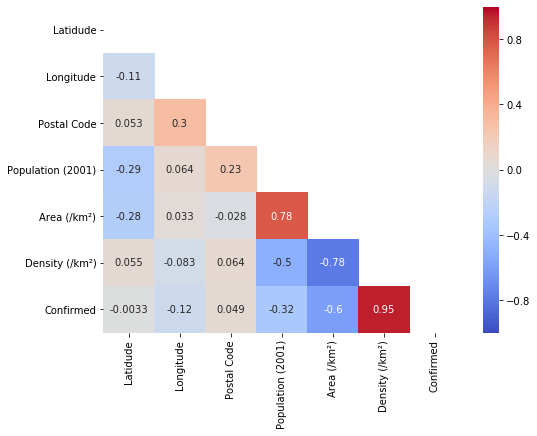

In [15]:
# We will check the correlation between the columns
fig = plt.figure(1, figsize=(8, 6))
df_corr = df_final.corr()
matrix = np.triu(df_corr)

ax=sns.heatmap(df_corr, annot = True, vmin=-1, vmax=1, center= 0, mask=matrix, cmap= 'coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


#Analysis of the above graph:
1. Confirmed cases and Density have a high relation with value of 0.95
2. Area and Confirmed cases have a negative relationship. Which means inversely proportional to each other.

Above is our final data which is available for analysis. 
Now we will start fetching the details of the Delhi from FourSquare API which is our main task.

In [16]:
#Our first step to consume our FourSquare API
CLIENT_ID = 'XXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50

In [17]:
#Providing the location as New Delhi
address = 'New Delhi'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

28.6141793 77.2022662


In [18]:
#We are providing search query as "Hospital" as we want information about the Hospitals in Delhi
#Providing radius as 100 Kms or 100000 metres
search_query = 'Hospital'
radius = 100000
print(search_query + ' .... OK!')

Hospital .... OK!


In [19]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=VGL2ZVWTN2BDINO0GCIP43DKECE4OBTRUBDIU3NVJPCXJOHS&client_secret=MXL32YRVCJFBWAUUDG33ISUN0JFZJCZMXMHKO5TN2TPHLMS5&ll=28.6141793,77.2022662&v=20180604&query=Hospital&radius=100000&limit=50'

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebd9d75d03993001bcd749e'},
 'response': {'venues': [{'id': '4e1f1430cc3f012b9756fdfd',
    'name': 'Dr. Ram Manohar Lohia Hospital',
    'location': {'address': 'Ram Manohar Lohia Hospital',
     'lat': 28.624654222133696,
     'lng': 77.20060862393855,
     'labeledLatLngs': [{'label': 'display',
       'lat': 28.624654222133696,
       'lng': 77.20060862393855}],
     'distance': 1177,
     'cc': 'IN',
     'city': 'New Delhi',
     'state': 'Delhi',
     'country': 'India',
     'formattedAddress': ['Ram Manohar Lohia Hospital',
      'New Delhi',
      'Delhi',
      'India']},
    'categories': [{'id': '4bf58dd8d48988d196941735',
      'name': 'Hospital',
      'pluralName': 'Hospitals',
      'shortName': 'Hospital',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1589485025',
    'hasPerk': False},
   {'id': '4be7f5fe947820a1dc44b4db'

In [21]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df_v2 = json_normalize(venues)
df_v2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.postalCode,location.neighborhood
0,4e1f1430cc3f012b9756fdfd,Dr. Ram Manohar Lohia Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1589485025,False,Ram Manohar Lohia Hospital,28.624654,77.200609,"[{'label': 'display', 'lat': 28.62465422213369...",1177,IN,New Delhi,Delhi,India,"[Ram Manohar Lohia Hospital, New Delhi, Delhi,...",NaN,NaN,NaN
1,4be7f5fe947820a1dc44b4db,Sir Gangaram Hospital | सर गंगाराम अस्पताल,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1589485025,False,Rajendra Nagar,28.638601,77.188884,"[{'label': 'display', 'lat': 28.6386009566119,...",3016,IN,Delhi,Delhi,India,"[Rajendra Nagar (Karol Bagh), Delhi, Delhi, In...",Karol Bagh,NaN,NaN
2,4f3a7e46e4b03d32dfbeb80a,Sucheta Kriplani Hospital Cafeteria,"[{'id': '4bf58dd8d48988d1c7941735', 'name': 'S...",v-1589485025,False,NaN,28.634001,77.221702,"[{'label': 'display', 'lat': 28.63400068219633...",2911,IN,NaN,NaN,India,[India],NaN,NaN,NaN
3,4d849f985ad3a09319ecd2fd,army hospital research and referal,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1589485025,False,near vasant vihar,28.586160,77.157681,"[{'label': 'display', 'lat': 28.58616016121680...",5358,IN,Delhi,Delhi,India,"[near vasant vihar (Dhaula Kuan), Delhi, Delhi...",Dhaula Kuan,NaN,NaN
4,4db647200437fa536a53e602,St. Stephen's Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1589485025,False,Tis Hazari,28.666454,77.214489,"[{'label': 'display', 'lat': 28.6664535219038,...",5940,IN,New Delhi,Delhi,India,"[Tis Hazari, New Delhi, Delhi, India]",NaN,NaN,NaN


In [25]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_v2.columns if col.startswith('location.')] + ['id']
dataframe_filtered = df_v2.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()


,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,postalCode,neighborhood,id
0,Dr. Ram Manohar Lohia Hospital,Hospital,Ram Manohar Lohia Hospital,28.624654,77.200609,"[{'label': 'display', 'lat': 28.62465422213369...",1177,IN,New Delhi,Delhi,India,"[Ram Manohar Lohia Hospital, New Delhi, Delhi,...",NaN,NaN,NaN,4e1f1430cc3f012b9756fdfd
1,Sir Gangaram Hospital | सर गंगाराम अस्पताल,Hospital,Rajendra Nagar,28.638601,77.188884,"[{'label': 'display', 'lat': 28.6386009566119,...",3016,IN,Delhi,Delhi,India,"[Rajendra Nagar (Karol Bagh), Delhi, Delhi, In...",Karol Bagh,NaN,NaN,4be7f5fe947820a1dc44b4db
2,Sucheta Kriplani Hospital Cafeteria,Snack Place,NaN,28.634001,77.221702,"[{'label': 'display', 'lat': 28.63400068219633...",2911,IN,NaN,NaN,India,[India],NaN,NaN,NaN,4f3a7e46e4b03d32dfbeb80a
3,army hospital research and referal,Hospital,near vasant vihar,28.586160,77.157681,"[{'label': 'display', 'lat': 28.58616016121680...",5358,IN,Delhi,Delhi,India,"[near vasant vihar (Dhaula Kuan), Delhi, Delhi...",Dhaula Kuan,NaN,NaN,4d849f985ad3a09319ecd2fd
4,St. Stephen's Hospital,Hospital,Tis Hazari,28.666454,77.214489,"[{'label': 'display', 'lat': 28.6664535219038,...",5940,IN,New Delhi,Delhi,India,"[Tis Hazari, New Delhi, Delhi, India]",NaN,NaN,NaN,4db647200437fa536a53e602


In [26]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11) 

# add a red circle marker to represent the New Delhi
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Hospitals',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Hospitals as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [27]:
#Now we are trying to fetch the data of a particular hospital using ID
venue_id='4c0b6d8f6071a5930644e132'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/4c0b6d8f6071a5930644e132?client_id=VGL2ZVWTN2BDINO0GCIP43DKECE4OBTRUBDIU3NVJPCXJOHS&client_secret=MXL32YRVCJFBWAUUDG33ISUN0JFZJCZMXMHKO5TN2TPHLMS5&v=20180604'

In [28]:
result = requests.get(url).json()
#print(result['response']['venue'].keys())
#result['response']['venue']

In [29]:
# Using below code to get the rating of the hospital
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


In [30]:
#venue_id = dataframe_filtered['id'][1]
venue_id = '4fc07ce6e4b0c9a9f10172cb' # ID of Hospital
#venue_id = dataframe_filtered['id'][6]
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue'].keys())
    print(result['response']['venue']['name'])
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


In [31]:
#venue_id = dataframe_filtered['id'][1]
venue_id = '507a79cbe4b01b417aabcd9d' # ID of Hospital
#venue_id = dataframe_filtered['id'][6]
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue'].keys())
    print(result['response']['venue']['id'])
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


So here all our data collection is complete.
This completes our first week Problem Statement and data collection.
Motivation behind doing this.

In [32]:
#now we will try to find the ratings of the hospitals in Delhi and if rating is not there, we need to handle 
#using missing values logic
for names, ids in zip(dataframe_filtered['name'],dataframe_filtered['id']):
    venue_ids = ids
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_ids, CLIENT_ID, CLIENT_SECRET, VERSION)      
    result = requests.get(url).json()
    try:
        dataframe_filtered['ratings'] = result['response']['venue']['rating']
    except:
        dataframe_filtered['ratings'] = float('NaN')

In [33]:
#now we have our ratings for the hospitals
#next step will be to fill the values which are null for the ratings
dataframe_filtered['ratings'] = dataframe_filtered['ratings'].fillna(dataframe_filtered['ratings'].mean())

In [34]:
#Also changing the name of the hospital column name to Names
dataframe_filtered = dataframe_filtered.rename(columns={'name':'Names'})

In [35]:
#Now we have all our ratings
#Next step will be to combine the df_final dataframe and dataframe_filtered dataframe
df_total = pd.merge(df_final,dataframe_filtered, on='Names')

In [36]:
df_total.head()

,Names,Sub Districts,Districts,Latidude,Longitude,State_x,Postal Code,Population (2001),Area (/km²),Density (/km²),...,cc,city,state,country,formattedAddress,crossStreet,postalCode,neighborhood,id,ratings
0,Dr. Ram Manohar Lohia Hospital,Connaught Place,New Delhi,28.624654,77.200609,Delhi,110001,302363,22,13744,...,IN,New Delhi,Delhi,India,"[Ram Manohar Lohia Hospital, New Delhi, Delhi,...",NaN,NaN,NaN,4e1f1430cc3f012b9756fdfd,NaN
1,Rml hospital,Connaught Place,New Delhi,28.636175,77.202007,Delhi,110001,302363,22,13744,...,IN,New Delhi,Delhi,India,"[New Delhi, Delhi, India]",NaN,NaN,NaN,4d194f59401db60c9da4f9a4,NaN
2,"Sucheta Kripalini hospital , new delhi",Connaught Place,New Delhi,28.638733,77.212539,Delhi,110001,302363,22,13744,...,IN,NaN,NaN,India,[India],NaN,NaN,NaN,51761cfde4b0565a0954a86a,NaN
3,ICARE Eye Hospital,Hauz Khas,New Delhi,28.579491,77.335896,Delhi,110016,302363,22,13744,...,IN,Noida,Uttar Pradesh,India,"[E-3A, Sector 26, Noida 201301, Uttar Pradesh,...",NaN,201301,NaN,4e28183e1fc7f0a6e1496ad5,NaN
4,Central Railway Hospital,Paharganj,Central Delhi,28.635998,77.216700,Delhi,110055,644005,25,25759,...,IN,New Delhi,Delhi,India,"[Panchkuian Road, New Delhi, Delhi, India]",NaN,NaN,NaN,4f1ab45be4b0c74ef10e0bd4,NaN


In [37]:
df_total.shape

(50, 27)

In [38]:
df_total.columns

Index(['Names', 'Sub Districts', 'Districts', 'Latidude', 'Longitude',
       'State_x', 'Postal Code', 'Population (2001)', 'Area (/km²)',
       'Density (/km²)', 'Confirmed', 'categories', 'address', 'lat', 'lng',
       'labeledLatLngs', 'distance', 'cc', 'city', 'state', 'country',
       'formattedAddress', 'crossStreet', 'postalCode', 'neighborhood', 'id',
       'ratings'],
      dtype='object')

In [39]:
label = df_total['Districts']

In [40]:
#now we will try to remove duplicate columns which are not of much use
df_total = df_total.drop(columns=['cc','city','state','country','formattedAddress','crossStreet',
                                  'postalCode','neighborhood','id','categories','address','lat','lng',
                                  'labeledLatLngs','distance'])
df_total.head()

,Names,Sub Districts,Districts,Latidude,Longitude,State_x,Postal Code,Population (2001),Area (/km²),Density (/km²),Confirmed,ratings
0,Dr. Ram Manohar Lohia Hospital,Connaught Place,New Delhi,28.624654,77.200609,Delhi,110001,302363,22,13744,37,NaN
1,Rml hospital,Connaught Place,New Delhi,28.636175,77.202007,Delhi,110001,302363,22,13744,37,NaN
2,"Sucheta Kripalini hospital , new delhi",Connaught Place,New Delhi,28.638733,77.212539,Delhi,110001,302363,22,13744,37,NaN
3,ICARE Eye Hospital,Hauz Khas,New Delhi,28.579491,77.335896,Delhi,110016,302363,22,13744,37,NaN
4,Central Railway Hospital,Paharganj,Central Delhi,28.635998,77.216700,Delhi,110055,644005,25,25759,184,NaN


In [41]:
#now we will remove the object columns for applying K Means Clustering(making data suitable for fitting the model)
df_nonObj = df_total.drop(columns=['Names','Sub Districts','Districts','Latidude','Longitude','State_x','Postal Code'])
df_nonObj.head()

,Population (2001),Area (/km²),Density (/km²),Confirmed,ratings
0,302363,22,13744,37,NaN
1,302363,22,13744,37,NaN
2,302363,22,13744,37,NaN
3,302363,22,13744,37,NaN
4,644005,25,25759,184,NaN


In [42]:
# As we can see, we have few null values in ratings, just to provide variations, let's assign random number to them
randomlist = []
total_len = len(df_nonObj['ratings'])
for i in range(0,total_len):
    n = random.randint(3,10)
    randomlist.append(n)
df_nonObj['ratings'] = randomlist
#print(df_nonObj['ratings'])

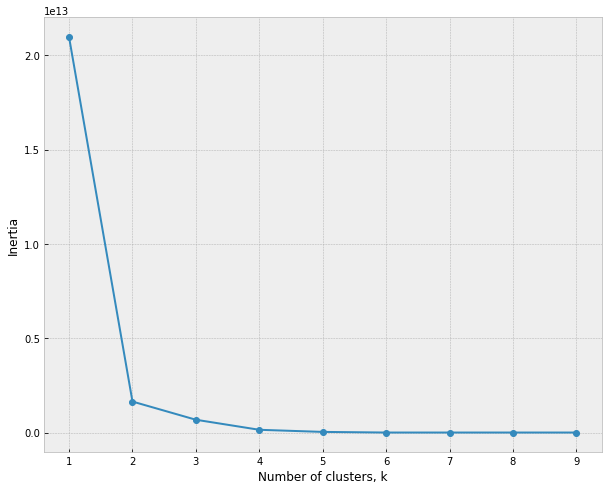

In [43]:
#check the optimal k value
ks = range(1,10)
inertias=[]
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_nonObj)
    inertias.append(model.inertia_)
plt.figure(figsize=(10,8)) 
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [44]:
def k_means(n_clust, data_frame, true_labels):
   
    k_means = KMeans(n_clusters = n_clust, random_state=123, n_init=30)
    k_means.fit(data_frame)
    c_labels = k_means.labels_
    df = pd.DataFrame({'clust_label': c_labels, 'orig_label': true_labels.tolist()})
    ct = pd.crosstab(df['clust_label'], df['orig_label'])
    y_clust = k_means.predict(data_frame)
    display(ct)
    print('% 9s' % 'inertia  homo    compl   v-meas   ARI     AMI     silhouette')
    print('%i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
      %(k_means.inertia_,
      homogeneity_score(true_labels, y_clust),
      completeness_score(true_labels, y_clust),
      v_measure_score(true_labels, y_clust),
      adjusted_rand_score(true_labels, y_clust),
      adjusted_mutual_info_score(true_labels, y_clust),
      silhouette_score(data_frame, y_clust, metric='euclidean')))

In [45]:
#privinding one of the optimal values of K
k_means(n_clust=5, data_frame=df_nonObj, true_labels=label)

orig_label,Central Delhi,New Delhi,North Delhi,North West Delhi,South Delhi,South West Delhi,West Delhi
clust_label,,,,,,,
0,0,0,0,0,4,0,3
1,15,0,0,0,0,0,0
2,0,0,0,0,0,15,0
3,0,4,0,0,0,0,0
4,0,0,2,7,0,0,0


inertia  homo    compl   v-meas   ARI     AMI     silhouette
33281287233   0.888   1.000   0.940   0.937   0.866    0.970


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [46]:
#Let's predict the values using our model
kmeans5 = KMeans(n_clusters=5)
y_kmeans5 = kmeans5.fit_predict(df_nonObj)
print(y_kmeans5)

[3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4
 4 4 4 4 4 4 2 2 2 2 2 2 2]


In [47]:
#Lets add the clusters in our dataframe
df_nonObj['cluster'] = y_kmeans5
df_nonObj.tail()

,Population (2001),Area (/km²),Density (/km²),Confirmed,ratings,cluster
45,2258367,250,9033,70,10,2
46,2258367,250,9033,70,7,2
47,2119641,112,18925,122,7,2
48,2119641,112,18925,122,10,2
49,2119641,112,18925,122,8,2


In [48]:
#get the values of our centroids of clusters
kmeans5.cluster_centers_

array([[1.74949200e+06, 3.95000000e+02, 4.43000000e+03, 4.20000000e+01,
        6.73333333e+00],
       [6.44005000e+05, 2.50000000e+01, 2.57590000e+04, 1.84000000e+02,
        6.20000000e+00],
       [2.19891300e+06, 1.90857143e+02, 1.32724286e+04, 9.22857143e+01,
        7.14285714e+00],
       [3.02363000e+05, 2.20000000e+01, 1.37440000e+04, 3.70000000e+01,
        8.00000000e+00],
       [7.84062667e+05, 1.14222222e+02, 7.58655556e+03, 3.82222222e+01,
        6.77777778e+00]])

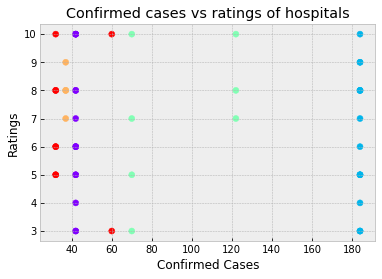

In [49]:
#confirmed cases vs ratings of hospitals
plt.title('Confirmed cases vs ratings of hospitals')
plt.xlabel('Confirmed Cases')
plt.ylabel('Ratings')
plt.scatter(df_nonObj['Confirmed'],df_nonObj['ratings'], c=y_kmeans5, cmap = 'rainbow')


From the above graph we can say that there is no linear relation between the Ratings and Confirmed Cases

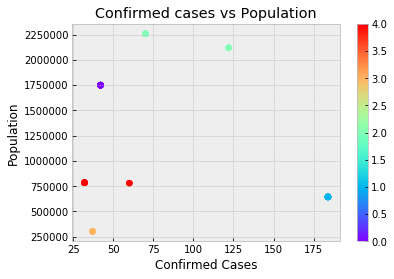

In [50]:
#confirmed cases vs Population
plt.title('Confirmed cases vs Population')
plt.xlabel('Confirmed Cases')
plt.ylabel('Population')
scatter= plt.scatter(df_nonObj['Confirmed'],df_nonObj['Population (2001)'], c=y_kmeans5, cmap = 'rainbow')
plt.colorbar(scatter)

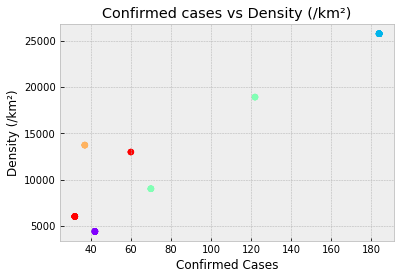

In [51]:
#confirmed cases vs Density
plt.title('Confirmed cases vs Density (/km²)')
plt.xlabel('Confirmed Cases')
plt.ylabel('Density (/km²)')
plt.scatter(df_nonObj['Confirmed'],df_nonObj['Density (/km²)'],c=y_kmeans5,  cmap = 'rainbow')


As we can see from the above graph that the density is linearly related to the Confirmed Cases.

Now we will create a folium map with clusters

In [55]:
df_nonObj['cluster'] = df_nonObj['cluster'].astype(str)
final_map = folium.Map(location=[latitude, longitude], zoom_start=11) 

# add a red circle marker to represent the New Delhi
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Hospitals',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add the Hospitals as blue circle markers
for lat, lng, label,dense,confm in zip(df_total.Latidude, df_total.Longitude, df_nonObj.cluster,df_total['Density (/km²)'],df_total.Confirmed):
    colors = ['blue', 'green', 'yellow', 'red', 'voilet']
    labels = '{}, {}, {}'.format(label, dense,confm)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=colors[int(label)],
        popup=labels,
        clustered_marker = True,
        fill = True,
        fill_color=colors[int(label)],
        fill_opacity=0.6
    ).add_to(final_map)

# display map
final_map

Cluster colors:
0 - Blue
1 - Green
2 - Yellow
3 - Red
4 - Violet

Result Section: 
1. Number of cases have a linear relationship with Population and Density.
2. Number of cases do not have linear relationship with Ratings of the hospitals.

Now we will observe the clusters
1. Blue cluster which are near New Delhi have low cases(at around 42 per district) and also having low density of 4430 per sqaure kms. Also this cluster have higher number of hospitals. 
2. Green cluster have highest cases of 184 and also high density of around 25759 per sqaure kms. This cluster have comparatively medium number of hospitals.
3. Yellow cluster have moderate cases of 70 and density of 9033 per sqaure kms. This cluster have low number of hospitals. 
4. Now red cluster have low cases of 37 per district and density of 13477 per square kms. This cluster have low number of hospitals.
5. Now Violet cluster have moderate cases of around 60 per district and density of 13000 square kms. Also having moderate number of hospitals. 

Recommendations we can make based on the results and we can also provide it to DELHI Government as a prototype:

1. Green cluster(mostly areas nearby Karol Bagh) needs to get more medical supplies in comparison to other clusters. 
2. After green cluster, yellow cluster needs to be taken care because of low hospitals and high cases. 
3. Then violet cluster(areas in north Delhi) needs supply of medicines and other amenities based on all the parameters. 

Conclusion:
So this concludes our observation. I hope these observations can help the required agencies.
If we have more data about Delhi and COVID-19, then we can provide more accurate predictions. 